## ICESat-2 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to calculate ATL06 elevations from ALT03 points and save those elevations as a CSV. 

Activate the sliderule_env enviroment to run

Last updated by Karina Zikan July 2023

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.9 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 265 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 9.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [12]:
# Specify region of interest shapefile
shp = "Sites/RCEW/ROIs/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

False

##### - Check shapefile crs

In [13]:
## if shapefile.crs is None is false check the crs
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### - Make Geojson

In [7]:
#shapefile.to_file('Sites/DCEW/ROIs/DCEW2bound_WGS84.geojson', driver='GeoJSON')

In [ ]:
## if shapefile.crs is None is true run this section
#crs = 'epsg:8826' # set the starting datum using the epsg code
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.set_crs(crs)
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

In [ ]:
## if shapefile.crs is not WGS84 run this section
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

#### 2. Read in geojson for Region of Interest

In [14]:
# Specify region of interest from geojson
poly_fn = 'Sites/RCEW/ROIs/RCEW-outline_WGS84.geojson'
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [15]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

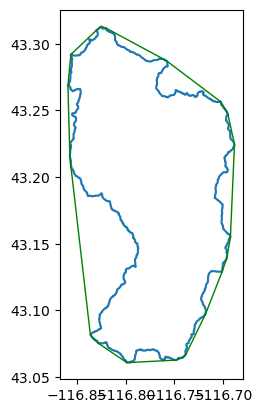

In [16]:
# Read geojson with geopandas
pregion = gpd.read_file(poly_fn)
map = pregion.plot(); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g'); # plot symplified region boundery for a sanity check

#### 3. Save simplified polygon

In [17]:
polygon_geom = Polygon(zip(region_lon, region_lat))
crs = 'epsg:4979'
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       

polygon

,geometry
0,"POLYGON ((-116.799 43.06089, -116.7954 43.0608..."


### Save to file if you haven't already

In [59]:
#polygon.to_file('Sites/DCEW/ROIs/DCEW2bound_WGS84_simple.geojson', driver='GeoJSON')

# Sliderule Product processing

Follow the processing section for the desired product

### - ATL06 and ATL06_classified processing 

Chose ATL06 or ATL06_clssified parameters depending on what product you are downloading

#### ATL06 Parameters

In [ ]:
parms = {
    "poly": region,
    "srt": 0,
    "cnf": icesat2.CNF_SURFACE_HIGH, 
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 6
}
cvs_name = "Sites/MCS/ROIs/MCS-ICESat2-ATL06.csv" #set name of the output

#### ATL06_classified Parameters

In [23]:
parms = {
    "poly": region,
    "srt": 0,
    "atl08_class": "atl08_ground",
    "cnf": icesat2.CNF_BACKGROUND, 
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 6
}
cvs_name = "Sites/RCEW/IS2_Data/RCEW-ICESat2-A6-40.csv" #set name of the output

#### Calculate Elevations

In [19]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
data = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
#print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(data.shape[0]))

Completed in 17.538 seconds of wall-clock time
Received 84040 elevations


## Plot ATL06 Results 

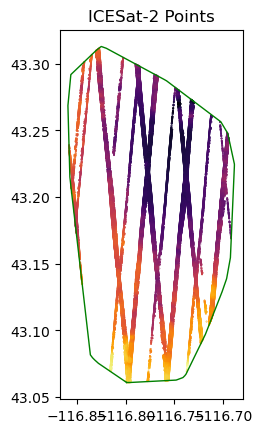

In [20]:
f, ax = plt.subplots()
ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
data.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g');

## Data Check

In [21]:
#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611' 

data['Longitude'] = data['geometry'].x
data['Latitude'] = data['geometry'].y
eastnorths = data['geometry'].to_crs(utm_code)
data['Easting'] = eastnorths.x
data['Northing'] = eastnorths.y
data

,segment_id,region,gt,spot,rgt,w_surface_window_final,rms_misfit,y_atc,x_atc,pflags,h_sigma,dh_fit_dx,cycle,h_mean,n_fit_photons,geometry,Longitude,Latitude,Easting,Northing
time,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:06.009938688,239591,2,20,5,905,5.214227e+00,0.341816,928.000916,4804686.5,0,0.118302,-0.203068,1,1418.891576,13,POINT (-116.69149 43.16892),-116.691486,43.168918,525078.707725,4.779619e+06
2018-11-26 21:09:06.012748288,239592,2,20,5,905,6.003153e+37,0.405302,928.033752,4804706.5,0,0.101415,-0.129099,1,1415.109474,16,POINT (-116.69151 43.1691),-116.691510,43.169098,525076.688845,4.779639e+06
2018-11-26 21:09:06.015550976,239593,2,20,5,905,6.003153e+37,0.497656,928.077820,4804726.5,0,0.207489,-0.098976,1,1412.797057,10,POINT (-116.69153 43.16928),-116.691534,43.169277,525074.658811,4.779659e+06
2018-11-26 21:09:06.021147904,239595,2,20,5,905,3.115877e+00,0.391529,928.157349,4804766.5,0,0.134737,-0.087848,1,1410.463856,14,POINT (-116.69158 43.16964),-116.691583,43.169636,525070.607256,4.779699e+06
2018-11-26 21:09:06.023947264,239596,2,20,5,905,4.502365e+37,0.180021,928.189331,4804787.0,0,0.035358,-0.141020,1,1408.069261,26,POINT (-116.69161 43.16982),-116.691606,43.169816,525068.589241,4.779718e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-20 06:55:08.974691584,762741,6,40,4,501,8.058585e+31,0.118300,11940.850586,15277184.0,0,0.038173,-0.014558,24,2075.224339,11,POINT (-116.75939 43.06345),-116.759393,43.063452,519592.539642,4.767889e+06
2024-07-20 06:55:08.988848128,762746,6,40,4,501,6.043939e+31,0.196559,11940.067383,15277284.0,0,0.064583,-0.007501,24,2073.936341,10,POINT (-116.75952 43.06256),-116.759522,43.062555,519582.318390,4.767789e+06
2024-07-20 06:55:08.991682304,762747,6,40,4,501,4.532954e+31,0.271220,11939.883789,15277304.0,0,0.081845,-0.019582,24,2073.675912,11,POINT (-116.75955 43.06238),-116.759548,43.062376,519580.247254,4.767769e+06


## Write CSV - ATL06

In [24]:
data.to_csv(cvs_name)